In [1]:
import numpy as np
import scipy

import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

In [2]:
class ImplicitMixer(nn.Module):
    def __init__(self, noise_dim, n_coeffs):
        super().__init__()
        self.noise_dim = noise_dim
        self.n_coeffs = n_coeffs
        
        self.encoder = nn.Sequential(nn.Linear(noise_dim, 100),
                                     nn.ReLU(),
                                     nn.Linear(100, 200),
                                     nn.ReLU(),
                                     nn.Linear(200, 100),
                                     nn.ReLU()
                                    )
        self.range_mean = nn.Linear(100, 1)
        self.nugget_mean = nn.Linear(100, 1)
        self.coeff_means = nn.Linear(100, n_coeffs)
    
    def forward(self, noise):
        enc = self.encoder(noise)
        return self.range_mean(enc), self.nugget_mean(enc), self.coeff_means(enc)

class QLogNormal(nn.Module):
    '''
    log normal conditional approximation for phi
    '''
    def __init__(self, sigma0=1.):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma0))
    
    def pdf(self, x, mu):
        ln = torch.distributions.LogNormal(mu, self.sigma)
        return torch.exp(ln.log_prob(x))
    
    def forward(self, mu):
        ln = torch.distributions.LogNormal(mu, self.sigma)
        return ln.rsample()

class QMVN(nn.Module):
    '''
    normal conditional approximation for beta
    '''
    def __init__(self, n_coeffs, cov_init = None):
        super().__init__()
        self.n_coeffs = n_coeffs
        if cov_init is not None:
            cov = cov_init
        else:
            cov = torch.diag(torch.ones(n_coeffs))
        self.cov = nn.Parameter(cov)
    
    def pdf(self, x, mu):
        mvn = torch.distributions.MultivariateNormal(mu, self.cov)
        return torch.exp(mvn.log_prob(x))
    
    def forward(self, mu):
        mvn = torch.distributions.MultivariateNormal(mu, self.cov)
        return mvn.rsample()
    
def train(y, X, s, range_prior, nugget_prior, coeff_prior, 
          q_range, q_nugget, q_coeff, mixer, optimizer, 
          K=20, J=10, iter=100, interval=100):
    dist_mat = torch.Tensor(scipy.spatial.distance_matrix(s, s))
    n = s.shape[0]
    losses = []
    for epoch in range(iter):
        if epoch % interval == 0: print("Iteration " + str(epoch))
        eps = torch.randn((K, mixer.noise_dim))
        range_means, nugget_means, coeff_means = mixer(eps)
        optimizer.zero_grad()
        loss = 0
        for j in range(J):
            eps_j = torch.randn((1, mixer.noise_dim))
            range_mean_j, nugget_mean_j, coeff_means_j = mixer(eps_j)
            range_sample = q_range(range_mean_j)
            nugget_sample = q_nugget(nugget_mean_j)
            coeff_sample = q_coeff(coeff_means_j)
            
            q_sum = q_range.pdf(range_sample, mu = range_means).sum() + \
                    q_nugget.pdf(nugget_sample, mu = nugget_means).sum() + \
                    q_coeff.pdf(coeff_sample, mu = coeff_means).sum()
            q_inner = q_range.pdf(range_sample, mu = range_mean_j) + \
                      q_nugget.pdf(nugget_sample, mu = nugget_mean_j) + \
                      q_coeff.pdf(coeff_sample, mu = coeff_means_j)
            log_H = -torch.log((q_sum + q_inner) / (K+1))
            
            cov_mat = exp_cov(dist_mat, phi = range_sample)
            model_cov = cov_mat + nugget_sample * torch.diag(torch.ones(n))
            model = torch.distributions.MultivariateNormal(loc = X.mm(coeff_sample.t()).t(),
                                                           covariance_matrix = model_cov)
            log_p = model.log_prob(y.t()) + \
                    range_prior.log_prob(range_sample) + \
                    nugget_prior.log_prob(nugget_sample) + \
                    coeff_prior.log_prob(coeff_sample)
            loss -= (log_H + log_p) / J
            
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
    return mixer, q_range, q_nugget, q_coeff, losses

In [3]:
def exp_cov(dists, phi, sigma=1):
    return sigma * torch.exp(- dists / phi)

def power_exp_cov(dists, phi, alpha):
    return torch.exp(- torch.pow(dists / phi, alpha))

## The data

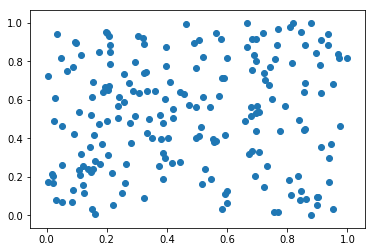

In [4]:
torch.manual_seed(0)
n = 200
s = torch.rand((n, 2))
plt.scatter(s[:,0].detach().numpy(), s[:, 1].detach().numpy(), marker = 'o')

In [5]:
phi_true = 5
tau2_true = 1
coeff_true = torch.Tensor([1, -5, 10]).view(3, 1)
X = torch.cat((torch.ones(n, 1), s), 1)

cov_mat = exp_cov(torch.Tensor(scipy.spatial.distance_matrix(s, s)), phi = phi_true)
nugget = torch.distributions.MultivariateNormal(
    loc = torch.zeros(n), covariance_matrix = tau2_true * torch.diag(torch.ones(n))
)
spatial = torch.distributions.MultivariateNormal(
    loc = torch.zeros(n), covariance_matrix = cov_mat
)
w = spatial.sample().view(n, 1)
eps = nugget.sample().view(n, 1)

y = X.mm(coeff_true) + w + eps

/Users/patrickding/anaconda3/lib/python3.6/site-packages/scipy/spatial/kdtree.py:74: RuntimeWarning: invalid value encountered in sqrt
  return minkowski_distance_p(x, y, p)**(1./p)


In [7]:
q_range = QLogNormal()
range_prior = torch.distributions.Uniform(.01, 10)
q_nugget = QLogNormal()
nugget_prior = torch.distributions.TransformedDistribution(
    torch.distributions.Gamma(2, 1),                                                           
    torch.distributions.transforms.PowerTransform(-1)
)
q_coeff = QMVN(coeff_true.shape[0])
coeff_prior = torch.distributions.MultivariateNormal(
    loc = torch.zeros(coeff_true.shape[0]), 
    covariance_matrix = 5 * torch.diag(torch.ones(3))
)

mixer_noise_dim = 50
mixer = ImplicitMixer(mixer_noise_dim, coeff_true.shape[0])

optimizer = torch.optim.Adam(list(mixer.parameters()) 
                             + list(q_range.parameters())
                             + list(q_nugget.parameters()) 
                             + list(q_coeff.parameters())
                             ,
                             lr = 0.01, betas = (.9, .999))

In [8]:
mixer, q_range, q_nugget, q_coeff, losses = \
    train(y, X, s, range_prior, nugget_prior, coeff_prior,
          q_range, q_nugget, q_coeff, mixer, optimizer,
          K = 20, J = 5, iter = 100, interval = 10)

/Users/patrickding/anaconda3/lib/python3.6/site-packages/scipy/spatial/kdtree.py:74: RuntimeWarning: invalid value encountered in sqrt
  return minkowski_distance_p(x, y, p)**(1./p)


Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90


In [9]:
n_plot_samples = 5000
eps = torch.randn((n_plot_samples, mixer.noise_dim))
range_mean, nugget_mean, coeff_mean = mixer(eps)
phi = q_range(range_mean)
tau2 = q_nugget(nugget_mean)
beta = q_coeff(coeff_mean)

In [10]:
phi.median()
tau2.median()
phi.std()
tau2.std()

tensor(0.3535, grad_fn=<StdBackward0>)

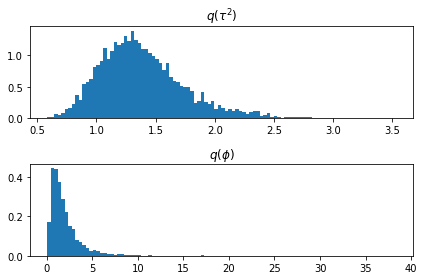

In [11]:
plt.subplot(2, 1, 1)
ax = plt.hist(tau2.detach().numpy(), density=True, label = '$q(\\tau^2)$',
            bins = 100)
plt.title('$q(\\tau^2)$')
plt.subplot(2, 1, 2)
plt.hist(phi.detach().numpy(), density=True, label = '$q(\phi)$',
            bins = 100)
plt.title('$q(\phi)$')

plt.tight_layout()

plt.savefig("sivi_var_posterior.pdf")

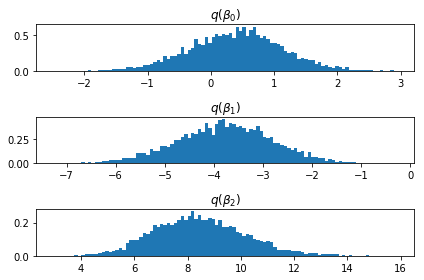

In [12]:
for i in range(beta.shape[1]):
    plt.subplot(3, 1, i+1)
    plt.hist(beta[:, i].detach().numpy(), density=True, label = '$q(\beta)$',
             bins = 100)
    plt.title("$q(\\beta_{})$".format(i))

plt.tight_layout()

plt.savefig("sivi_beta_posterior.pdf")

In [13]:
beta.mean(0)
beta.std(0)

tensor([0.7304, 0.9915, 1.7121], grad_fn=<StdBackward1>)

Text(0.5,0,'Iteration')

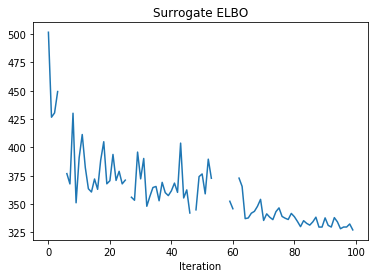

In [14]:
plt.figure()
plt.plot(torch.cat(losses).detach().numpy())
plt.title("Surrogate ELBO")
plt.xlabel("Iteration")

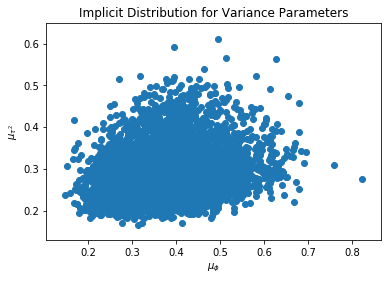

In [16]:
plt.figure()
plt.scatter(range_mean.detach().numpy(), nugget_mean.detach().numpy())
plt.xlabel("$\mu_\phi$")
plt.ylabel("$\mu_{\\tau^2}$")
plt.title("Implicit Distribution for Variance Parameters")
plt.savefig("sivi_var_corr.pdf")